In [1]:
%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
import scipy.io
import seaborn as sns
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from sklearn.model_selection import KFold
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import clear_output, display
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.cross_decomposition import PLSRegression 
from sklearn.metrics import mean_squared_error as MSE
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
from tensorly.decomposition import robust_pca
from sklearn.cross_decomposition import CCA
from sklearn.linear_model import LinearRegression
from tensorly.regression.cp_regression import CPRegressor
from tensorly.regression.tucker_regression import TuckerRegressor
from hopls import matricize, qsquared, HOPLS
import random
from qpfs import *
random_seed = 5
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
!CUBLAS_WORKSPACE_CONFIG=:16:8#:4096:8
device='cuda:0'

In [2]:
# Plotting train and test losses
def visualize(fig, train_loss, test_loss, clean=True):
    if clean:
        fig.clear()
    plt.plot(train_loss, color='red',label='train')
    plt.plot(test_loss, color='blue',label='test')
    plt.grid(linestyle='--')
    plt.yscale('log')
    plt.legend()
    if clean:
        clear_output(wait=True)
        display(fig);
    else:
        plt.show()

### Functions for PLS, CCA, HOPLS

In [3]:
def get_autoreg_Y(Y, step=1):
    m, t = Y.shape
    ar = np.zeros((m - step + 1, t * step))
    for i in range(step):
        for k in range(t):
            ar[:, i * t + k] = Y[i: m + i - step + 1, k]

    return ar

def get_bootstrap(X, Y):
    n = X.shape[0]
    idxs = np.random.choice(np.arange(n), size=n)
    return X[idxs], Y[idxs]

In [19]:
def CCA_PLS_test(Y_train, Y_test, X_train, X_test, k_max, algorithm = 'CCA', plot=True):
    step = 3
    n_restarts = 5

    Ytrain_ar, Ytest_ar = get_autoreg_Y(Y_train, step), get_autoreg_Y(Y_test, step)
    Xtrain_ar, Xtest_ar = X_train[:X_train.shape[0] - step + 1], X_test[:X_test.shape[0] - step + 1]

    rmse = []
    for k in range(1, k_max):#tqdm(range(1, k_max)):
        if algorithm == 'CCA':
            pls = CCA(n_components=k)
        else:
            pls = PLSRegression(n_components=k)
        tr = []
        te = []
        for i in range(n_restarts):
            X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
            pls.fit(X, Y)
            tr.append(metric_nmse(X, Y, pls))
            te.append(metric_nmse(Xtest_ar, Ytest_ar, pls))
        rmse.append((k, tr, te))

    x = [r[0] for r in rmse]
    y1_mean = np.array([np.mean(r[1]) for r in rmse])
    y2_mean = np.array([np.mean(r[2]) for r in rmse])
    y1_std = np.array([np.std(r[1]) for r in rmse])
    y2_std = np.array([np.std(r[2]) for r in rmse])
    if plot:
        plt.figure(figsize=(6, 5))

        plt.plot(x, y1_mean, label='train')
        plt.fill_between(x, y1_mean - y1_std, y1_mean + y1_std, alpha=0.3)

        plt.plot(x, y2_mean, label='test')
        plt.fill_between(x, y2_mean - y2_std, y2_mean + y2_std, alpha=0.3)
        plt.ylabel(r'sRMSE')
        plt.xlabel(algorithm + r'latent space dimensionality, $l$')

        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

        print(np.argmin(np.array(y2_mean))+1,'components with nRMSE =', min(y2_mean))
    return min(y2_mean)

def compute_rmse_hopls(tdata, tlabel, vdata, vlabel, Ln, Km, R_max=30):
    model = HOPLS(R_max, Ln, Km, epsilon=1e-3)
    model.fit(tdata, tlabel)
    prediction, R, prediction_scores = model.predict(vdata, vlabel)
    rmse_test = metric_nmse_(prediction.detach().numpy(), vlabel.detach().numpy())
    prediction, R, prediction_scores = model.predict(tdata, tlabel)
    rmse_train = metric_nmse_(prediction.detach().numpy(), tlabel.detach().numpy())
    return rmse_test, rmse_train, R

In [16]:
def metric_nmse_(Y_pred, Y):
    Y_base = Y.mean(axis=0)
    return np.mean(np.sqrt(np.mean((Y - Y_pred) ** 2, axis=0)) / np.sqrt(np.mean((Y - Y_base) ** 2, axis=0)))

### Loss functions
##### Base loss function:
$$ \mathcal{L} = \mathcal{L}_{rec} + l \cdot \mathcal{L}_{dec},$$
where:
$$ \mathcal{L}_{rec} = \frac{1}{n} \sum_{i=1}^{n} \left( X_i - \psi \circ \phi (X_i) \right)^2 $$
$$ \mathcal{L}_{dec} = \frac{1}{m} \sum_{i=1}^{m} \left( Y_i - \omega \circ \phi (X_i) \right)^2 $$
where $n,m$ - number of elements of $X,~Y,$ respectively. $\psi$ - encoder, $\phi$ - decoder, $\omega$ - linear layer to predict $Y$.

In [6]:
def compute_pearson(input):
    """
    input: tensor [b,c,n] or [b,c,h,w]
    return: pearson correlation coefficient [c,c]
    """
    batch, channel,_ = input.shape
    input = input.view(batch, channel,-1)
    mean = torch.mean(input,dim=0).unsqueeze(0)
    cov = torch.matmul(input-mean,(input-mean).permute(0,2,1))
    diag = torch.sum(torch.eye(channel).unsqueeze(0).to(device) * cov,dim=2).view(batch,channel,-1)
    stddev = torch.sqrt(torch.matmul(diag,diag.permute(0,2,1)))
    pearson = torch.div(cov,stddev)
    return pearson

In [7]:
def my_loss(l):
    def loss_(X, y, out, y_pred):
        return ((X-out)**2).mean() + l * ((y-y_pred)**2).mean()
    return loss_

def my_loss_Q(l,m):
    def loss_(X, y, out, y_pred, code):
        return ((X-out)**2).mean() + l * ((y-y_pred)**2).mean() + m * torch.mean(compute_pearson(code.reshape(X.size(0),-1,1)))
    return loss_

## Data

Data from electrocorticogram (ECoG). They consists of $32-$ time series (channels). The original signals are converted into a space time representation using a wavelet transform with Morlet wavelet. So, $X \in \mathbb{R}^{T \times 32 \times 27}$, where 27 - number of frequencies. $Y \in \mathbb{R}^{T \times 3}$ - coordinates of hand position.

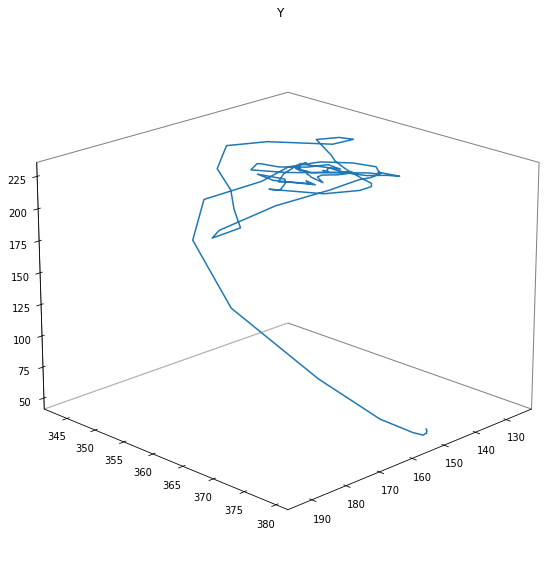

In [8]:
Y = scipy.io.loadmat('ECoG_Y_train.mat')['Y_train']
for i,data in [('Y',Y)]:
    with PdfPages(i+'.pdf') as pdf:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(data[50:160,0],
                data[50:160,1],
                data[50:160,2],
                label='parametric curve')
        ax.grid(False)
        ax.set_title(i)
        ax.xaxis.set_rotate_label(False)
        ax.yaxis.set_rotate_label(False)
        ax.zaxis.set_rotate_label(False)
        ax.view_init(elev=20, azim=45)
        ax.xaxis.pane.set_edgecolor('black')
        ax.yaxis.pane.set_edgecolor('black')
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False
        pdf.savefig()

Text(0.5, 1.0, 'X')

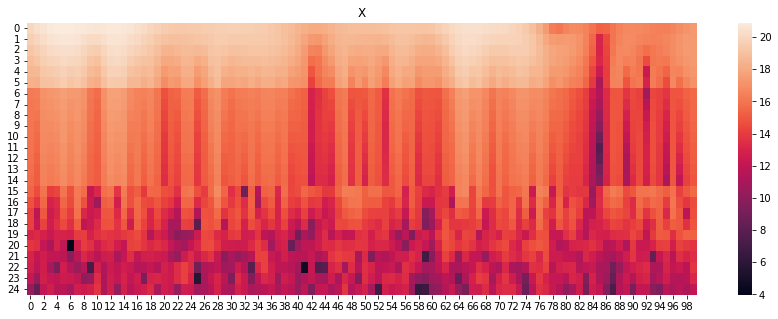

In [9]:
X = scipy.io.loadmat('ECoG_X_train.mat')['X_train']
f, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(X[:100,1,2:].T)
ax.set_title('X')

In [10]:
X_test = torch.from_numpy(scipy.io.loadmat('ECoG_X_test.mat')['X_hold_out']).to(torch.float32).permute(0,2,1).to(device)
Y_test = torch.from_numpy(scipy.io.loadmat('ECoG_Y_test.mat')['Y_hold_out']).to(torch.float32).to(device)
X_train = torch.from_numpy(scipy.io.loadmat('ECoG_X_train.mat')['X_train']).to(torch.float32).permute(0,2,1).to(device)
Y_train = torch.from_numpy(scipy.io.loadmat('ECoG_Y_train.mat')['Y_train']).to(torch.float32).to(device)

print('X train:', X_train.size())
print('Y train:', Y_train.size())
print('X test:', X_test.size())
print('Y test:', Y_test.size())

X_test = (X_test - X_test.mean()) / X_test.std() 
Y_test = (Y_test - Y_test.mean()) / Y_test.std()
X_train = (X_train - X_train.mean()) / X_train.std()
Y_train = (Y_train - Y_train.mean()) / Y_train.std()

IMAGE_WIDTH = X_train.shape[1]
IMAGE_HEIGHT = X_train.shape[2]
IMAGE_SIZE = IMAGE_WIDTH * IMAGE_HEIGHT

batch_size = 1024
train = data_utils.TensorDataset(X_train, Y_train)
test = data_utils.TensorDataset(X_test, Y_test)
train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = data_utils.DataLoader(test, batch_size=batch_size, shuffle=True)

X train: torch.Size([12801, 27, 32])
Y train: torch.Size([12801, 3])
X test: torch.Size([6087, 27, 32])
Y test: torch.Size([6087, 3])


## PLS, CCA and HOPLS results

In [ ]:
CCA_PLS_test(Y_train.cpu(), Y_test.cpu(), X_train.cpu().reshape(-1,27*32), X_test.cpu().reshape(-1,27*32), 20, algorithm = 'PLS')

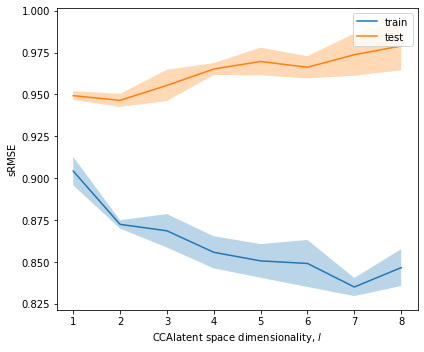

2 components with nRMSE = 0.9464764105802702


0.9464764105802702

In [13]:
CCA_PLS_test(Y_train.cpu(), Y_test.cpu(), X_train.cpu().reshape(-1,27*32), X_test.cpu().reshape(-1,27*32), 9)

In [20]:
MSE_test = {}
MSE_train = {}
for ks1 in tqdm(range(1,27,3)):
    for ks2 in range(1,32,5):
        for ks3 in range(1,4):
            Ln = [ks1,ks2]
            Km = [ks3]
            rmse_test, rmse_train, R = compute_rmse_hopls(X_train.cpu().double(), Y_train.cpu().double(), X_test.cpu().double(), Y_test.cpu().double(), Ln, Km, R_max=20)
            MSE_test[f'Ln = ({ks1},{ks2}), Km = {ks3}'] = rmse_test
            MSE_train[f'Ln = ({ks1},{ks2}), Km = {ks3}'] = rmse_train

print('Train. Size of core tensor is', min(MSE_train, key=MSE_train.get), 'nRMSE =', MSE_train[min(MSE_train, key=MSE_train.get)])
print('Test. Size of core tensor is', min(MSE_test, key=MSE_test.get), 'nRMSE =', MSE_test[min(MSE_test, key=MSE_test.get)])

100%|██████████| 9/9 [10:35<00:00, 70.65s/it]

Train. Size of core tensor is Ln = (1,1), Km = 2 nRMSE = 1.1231276128942167
Test. Size of core tensor is Ln = (1,1), Km = 1 nRMSE = 1.1389105353794278


## Autoencoder with matrix output

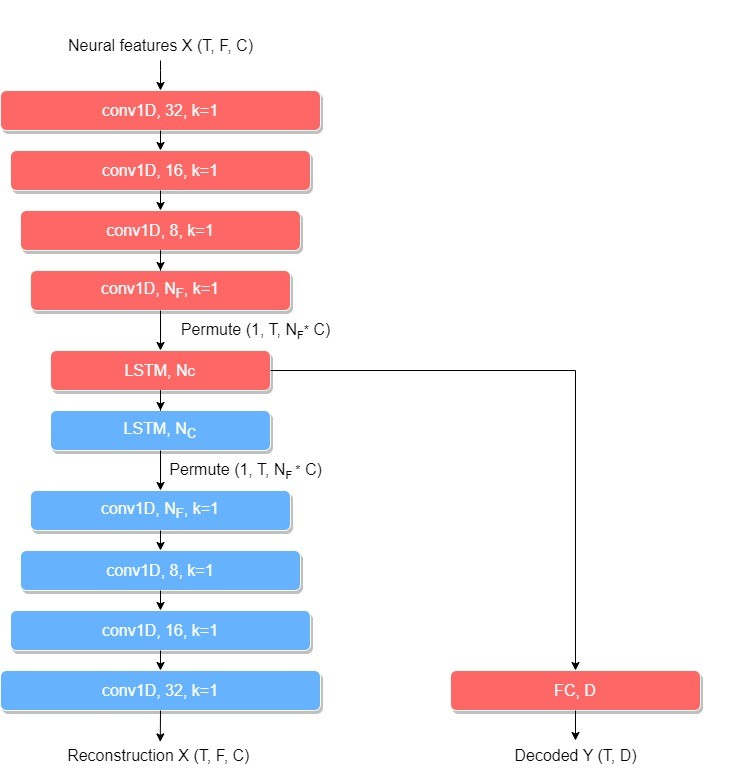

#### Model

In [17]:
class AutoEncoder(nn.Module):
    
    def __init__(self, N_ch, N_f):
        super().__init__()
        self.N_ch = N_ch
        self.N_f = N_f
        # Encoder specification
        self.enc_cnn_1 = nn.Sequential(
            nn.Conv1d(IMAGE_WIDTH, 32, 1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(p=0.05)) 
        self.enc_cnn_2 = nn.Sequential(
            nn.Conv1d(32, 16, 1),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Dropout(p=0.05)) 
        if N_ch >= 8:
            self.enc_cnn_3 = nn.Sequential(
                nn.Conv1d(16, N_f, 1),
                nn.BatchNorm1d(N_f),
                nn.GELU(),
                nn.Dropout(p=0.05))
        elif N_ch < 8:
            self.enc_cnn_3 = nn.Sequential(
                nn.Conv1d(16, 8, 1),
                nn.BatchNorm1d(8),
                nn.GELU(),
                nn.Dropout(p=0.05))
            self.enc_cnn_4 = nn.Sequential(
                nn.Conv1d(8, N_f, 1),
                nn.BatchNorm1d(N_f),
                nn.GELU(),
                nn.Dropout(p=0.05))
        self.enc_lstm = nn.LSTM(N_f*IMAGE_HEIGHT, N_ch, 1)
        
        # Decoder specification
        self.dec_lstm = nn.LSTM(N_ch, N_f*IMAGE_HEIGHT, 1)
        if N_ch < 8:
            self.dec_cnn_1 = nn.Sequential(
                nn.Conv1d(N_f, 8, 1),
                nn.BatchNorm1d(8),
                nn.GELU(),
                nn.Dropout(p=0.05))
            self.dec_cnn_2 = nn.Sequential(
                nn.Conv1d(8, 16, 1),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Dropout(p=0.05)) 
        else:
            self.dec_cnn_2 = nn.Sequential(
                nn.Conv1d(N_f, 16, 1),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Dropout(p=0.05))
        self.dec_cnn_3 = nn.Sequential(
            nn.Conv1d(16, 32, 1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(p=0.05))
        self.dec_cnn_4 = nn.Sequential(
            nn.Conv1d(32, IMAGE_WIDTH, 1),
            nn.BatchNorm1d(IMAGE_WIDTH),
            nn.GELU(),
            nn.Dropout(p=0.05))
        
        self.fc = nn.Linear(N_ch, 3)
        
    def forward(self, images):
        code = self.encode(images)
        y_pred = self.fc(code)
        out = self.decode(code)
        return out, y_pred, code
    
    def encode(self, images):
        code = self.enc_cnn_1(images)
        code = self.enc_cnn_2(code)
        if self.N_ch < 8:
            code = self.enc_cnn_3(code)
            code = self.enc_cnn_4(code)
        else:
            code = self.enc_cnn_3(code)
        code = code.reshape([1,code.size(0),code.size(2)*code.size(1)])
        code,_ = self.enc_lstm(code)
        return code
    
    def decode(self, code):
        out,_ = self.dec_lstm(code)
        out = out.reshape([out.size(1),self.N_f,out.size(2)//self.N_f])
        if self.N_ch < 8:
            out = self.dec_cnn_1(out)
            out = self.dec_cnn_2(out)
        else:
            out = self.dec_cnn_2(out)
        out = self.dec_cnn_3(out)
        out = self.dec_cnn_4(out)
        return out

#### Finding best parameters

In [19]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

lr = 0.01
optimizer_cls = optim.Adam
MSE = []
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
# Finding best N
for n,N_ch in enumerate(range(10,32,3)):
    for k,N_f in enumerate(range(1,16,2)):
        MSE.append([])
        for train_index, test_index in tqdm(kf.split(X_train)):
        # Instantiate model
            autoencoder = AutoEncoder(N_ch,N_f).to(device)
            loss_fn = my_loss(3)
            optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
            epoch_train_loss = []
            epoch_test_loss = []
            
            train = data_utils.TensorDataset(X_train[train_index], Y_train[train_index])
            train_loader_ = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)
            
            for epoch in range(100):
                epoch_loss = []
                for x,y in train_loader_:
                    out, y_pred, code = autoencoder(x.double())
                    optimizer.zero_grad()
                    loss = loss_fn(x.double(), y.double(), out.double(), y_pred.double())
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    epoch_loss.append(loss.item())
                epoch_train_loss.append(np.array(epoch_loss).mean())
                
                with torch.no_grad():
                    out, y_pred, code = autoencoder(X_train[test_index].double())
                    optimizer.zero_grad()
                    loss = loss_fn(X_train[test_index].double(), Y_train[test_index].double(), out.double(), y_pred.double())
                    epoch_test_loss.append(loss.item())
                    
            X_train_lower = autoencoder.encode(X_train[train_index].double()).cpu().detach().numpy().reshape(-1,N_ch)
            X_test_lower = autoencoder.encode(X_train[test_index].double()).cpu().detach().numpy().reshape(-1,N_ch)
            lregr = LinearRegression()
            lregr.fit(X_train_lower,Y_train[train_index].cpu().detach().numpy())
            rmse = metric_nmse(X_test_lower,Y_train[test_index].cpu().detach().numpy(), lregr)
            MSE[n*8+k].append(rmse)

3it [01:22, 27.34s/it]
3it [01:23, 27.72s/it]
3it [01:28, 29.35s/it]
3it [01:39, 33.04s/it]
3it [01:50, 36.93s/it]
3it [02:03, 41.16s/it]
3it [02:12, 44.19s/it]
3it [02:32, 50.79s/it]
3it [01:20, 26.88s/it]
3it [01:22, 27.54s/it]
3it [01:27, 29.28s/it]
3it [01:38, 32.69s/it]
3it [01:49, 36.66s/it]
3it [02:02, 40.83s/it]
3it [02:12, 44.30s/it]
3it [02:32, 50.92s/it]
3it [01:21, 27.05s/it]
3it [01:22, 27.64s/it]
3it [01:27, 29.32s/it]
3it [01:38, 32.95s/it]
3it [01:50, 36.69s/it]
3it [02:02, 40.90s/it]
3it [02:13, 44.64s/it]
3it [02:34, 51.40s/it]
3it [01:22, 27.36s/it]
3it [01:23, 27.98s/it]
3it [01:29, 29.71s/it]
3it [01:40, 33.40s/it]
3it [01:51, 37.04s/it]
3it [02:29, 49.94s/it]
3it [02:48, 56.21s/it]
3it [03:16, 65.44s/it]
3it [01:38, 32.69s/it]
3it [01:41, 33.91s/it]
3it [01:47, 35.97s/it]
3it [02:04, 41.39s/it]
3it [02:16, 45.48s/it]
3it [02:37, 52.38s/it]
3it [02:51, 57.07s/it]
3it [03:19, 66.34s/it]
3it [01:39, 33.15s/it]
3it [01:41, 33.68s/it]
3it [01:50, 36.76s/it]
3it [02:01,

In [20]:
rmse = 2
N, K = 0, 0
for n,N_ch in enumerate(range(10,32,3)):
    for k,N_f in enumerate(range(1,16,2)):
        if rmse > np.array(MSE[n*8+k]).mean():
            N = N_ch
            K = N_f
            rmse = np.array(MSE[n*8+k]).mean()
print(r'$N_f =$',K,r'$N_ch =$',N,'- the best parameters of MatrixAutoencoder with nRMSE =', round(rmse,3))

$N_f =$ 3 $N_ch =$ 19 - the best parameters of MatrixAutoencoder with nRMSE = 1.071


#### Training with best parameters

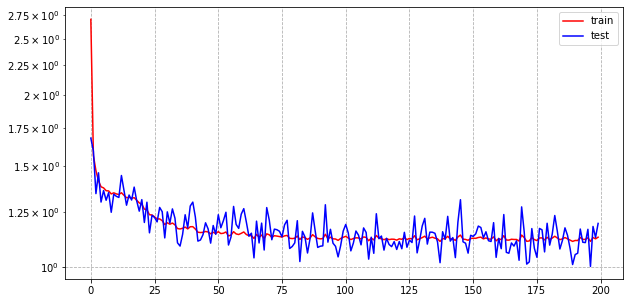

Number of parameters: 57106
nRMSE = 0.924719709153074


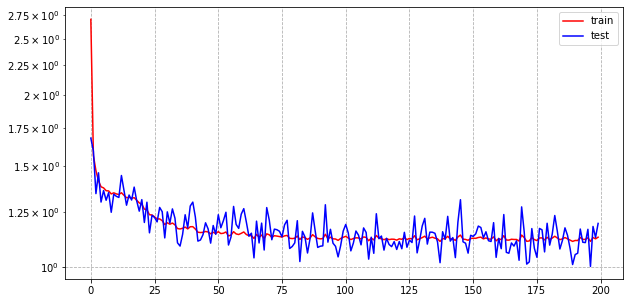

In [21]:
#N, K = 13, 13

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

lr = 0.01
optimizer_cls = optim.Adam

autoencoder = AutoEncoder(N, K).to(device)
loss_fn = my_loss(3)
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
epoch_test_loss = []
loss_train = []
fig = plt.figure(figsize=(10,5)) 

for epoch in range(200):
    loss_epoch_tr = []
    for x, y in train_loader:
        out, y_pred, code = autoencoder(x.double())
        optimizer.zero_grad()
        loss = loss_fn(x.double(), y.double(), out.double(), y_pred.double())
        loss.backward()
        optimizer.step()
        loss_epoch_tr.append(loss.item())
        scheduler.step()
    loss_train.append(np.array(loss_epoch_tr).mean())
    
    with torch.no_grad():
        out, y_pred, code = autoencoder(x.double())
        optimizer.zero_grad()
        loss = loss_fn(x.double(), y.double(), out.double(), y_pred.double())
        epoch_test_loss.append(loss.item())
    visualize(fig, loss_train, epoch_test_loss); 
    
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy().reshape(-1,N)
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy().reshape(-1,N)
lregr = LinearRegression()
lregr.fit(X_train_lower,Y_train.cpu().detach().numpy())
rmse = metric_nmse(X_test_lower,Y_test.cpu().detach().numpy(), lregr);
print('Number of parameters:',sum(p.numel() for p in autoencoder.parameters()))
print('nRMSE =', rmse)

## Autoencoder with tensor output

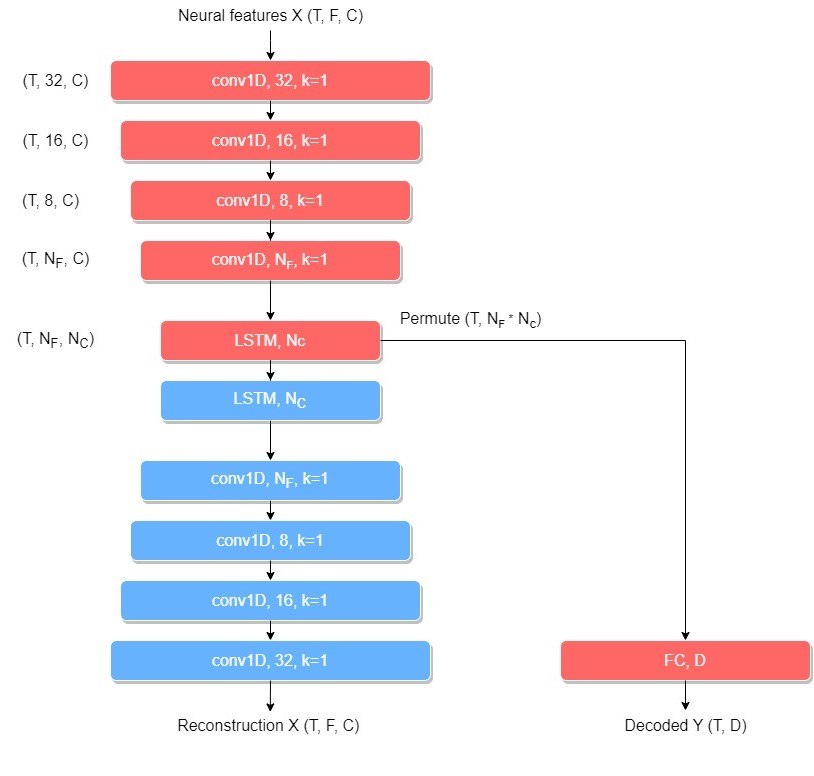

#### Model 

In [12]:
class AutoEncoder_(nn.Module):
    
    def __init__(self, N_ch, N_f):
        super().__init__()
        self.N_ch = N_ch
        self.N_f = N_f
        # Encoder specification
        self.enc_cnn_1 = nn.Sequential(
            nn.Conv1d(IMAGE_WIDTH, 32, 1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(p=0.05))
        self.enc_cnn_2 = nn.Sequential(
            nn.Conv1d(32, 16, 1),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Dropout(p=0.05)) 
        if N_ch >= 8:
            self.enc_cnn_3 = nn.Sequential(
                nn.Conv1d(16, N_f, 1),
                nn.BatchNorm1d(N_f),
                nn.GELU(),
                nn.Dropout(p=0.05))
        elif N_ch < 8:
            self.enc_cnn_3 = nn.Sequential(
                nn.Conv1d(16, 8, 1),
                nn.BatchNorm1d(8),
                nn.GELU(),
                nn.Dropout(p=0.05))
            self.enc_cnn_4 = nn.Sequential(
                nn.Conv1d(8, N_f, 1),
                nn.BatchNorm1d(N_f),
                nn.GELU(),
                nn.Dropout(p=0.05))
        self.enc_lstm = nn.LSTM(IMAGE_HEIGHT, N_ch, 1,batch_first=True)
        
        # Decoder specification
        self.dec_lstm = nn.LSTM(N_ch, IMAGE_HEIGHT, 1,batch_first=True)
            
        if N_ch < 8:
            self.dec_cnn_1 = nn.Sequential(
                nn.Conv1d(N_f, 8, 1),
                nn.BatchNorm1d(8),
                nn.GELU(),
                nn.Dropout(p=0.05))
            self.dec_cnn_2 = nn.Sequential(
                nn.Conv1d(8, 16, 1),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Dropout(p=0.05)) 
        else:
            self.dec_cnn_2 = nn.Sequential(
                nn.Conv1d(N_f, 16, 1),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Dropout(p=0.05))
        self.dec_cnn_3 = nn.Sequential(
            nn.Conv1d(16, 32, 1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(p=0.05))
        self.dec_cnn_4 = nn.Sequential(
            nn.Conv1d(32, IMAGE_WIDTH, 1),
            nn.BatchNorm1d(IMAGE_WIDTH),
            nn.GELU(),
            nn.Dropout(p=0.05))
        
        self.fc = nn.Linear(N_ch*N_f, 3)
        
    def forward(self, images):
        code = self.encode(images)
        y_pred = self.fc(code.reshape([1,code.size(0),self.N_f*self.N_ch]))
        out = self.decode(code)
        return out, y_pred, code
    
    def encode(self, images):
        code = self.enc_cnn_1(images)
        code = self.enc_cnn_2(code)
        if self.N_ch < 8:
            code = self.enc_cnn_3(code)
            code = self.enc_cnn_4(code)
        else:
            code = self.enc_cnn_3(code)
        #code = code.reshape([1,code.size(0),code.size(2)*2])
        code,_ = self.enc_lstm(code)
        return code
    
    def decode(self, code):
        out,_ = self.dec_lstm(code)
        #out = out.reshape([out.size(1),2,out.size(2)//2])
        if self.N_ch < 8:
            out = self.dec_cnn_1(out)
            out = self.dec_cnn_2(out)
        else:
            out = self.dec_cnn_2(out)
        out = self.dec_cnn_3(out)
        out = self.dec_cnn_4(out)
        return out

#### Finding best parameters

In [23]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

lr = 0.01
optimizer_cls = optim.Adam
MSE = []
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
# Finding best N
for n,N_ch in enumerate(range(2,20,1)):
    for k,N_f in enumerate(range(2,16,2)):
        MSE.append([])
        for train_index, test_index in tqdm(kf.split(X_train)):
        # Instantiate model
            autoencoder = AutoEncoder_(N_ch,N_f).to(device)
            loss_fn = my_loss(3)
            optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
            epoch_train_loss = []
            epoch_test_loss = []
            
            train = data_utils.TensorDataset(X_train[train_index], Y_train[train_index])
            train_loader_ = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)
            
            for epoch in range(100):
                epoch_loss = []
                for x,y in train_loader_:
                    out, y_pred, code = autoencoder(x.double())
                    optimizer.zero_grad()
                    loss = loss_fn(x.double(), y.double(), out.double(), y_pred.double())
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    epoch_loss.append(loss.item())
                epoch_train_loss.append(np.array(epoch_loss).mean())
                
                with torch.no_grad():
                    out, y_pred, code = autoencoder(X_train[test_index].double())
                    optimizer.zero_grad()
                    loss = loss_fn(X_train[test_index].double(), Y_train[test_index].double(), out.double(), y_pred.double())
                    epoch_test_loss.append(loss.item())
                    
            X_train_lower = autoencoder.encode(X_train[train_index].double()).cpu().detach().numpy().reshape(-1,N_f*N_ch)
            X_test_lower = autoencoder.encode(X_train[test_index].double()).cpu().detach().numpy().reshape(-1,N_f*N_ch)
            lregr = LinearRegression()
            lregr.fit(X_train_lower,Y_train[train_index].cpu().detach().numpy())
            rmse = metric_nmse(X_test_lower,Y_train[test_index].cpu().detach().numpy(), lregr)
            MSE[n*7+k].append(rmse)

3it [01:57, 39.19s/it]
3it [02:16, 45.37s/it]
3it [02:33, 51.11s/it]
3it [02:53, 57.67s/it]
3it [03:18, 66.32s/it]
3it [03:23, 67.93s/it]
3it [03:46, 75.53s/it]
3it [01:56, 38.98s/it]
3it [02:16, 45.43s/it]
3it [02:32, 50.85s/it]
3it [02:52, 57.57s/it]
3it [03:14, 64.78s/it]
3it [03:38, 72.87s/it]
3it [04:15, 85.03s/it]
3it [01:39, 33.33s/it]
3it [01:54, 38.04s/it]
3it [02:07, 42.54s/it]
3it [02:21, 47.15s/it]
3it [02:37, 52.33s/it]
3it [02:51, 57.12s/it]
3it [03:07, 62.55s/it]
3it [01:37, 32.62s/it]
3it [01:52, 37.37s/it]
3it [02:07, 42.37s/it]
3it [02:21, 47.31s/it]
3it [02:37, 52.66s/it]
3it [02:51, 57.26s/it]
3it [03:07, 62.62s/it]
3it [01:38, 32.67s/it]
3it [01:52, 37.46s/it]
3it [02:07, 42.52s/it]
3it [02:21, 47.19s/it]
3it [02:38, 52.81s/it]
3it [02:53, 57.69s/it]
3it [03:08, 62.78s/it]
3it [01:38, 32.82s/it]
3it [01:52, 37.38s/it]
3it [02:07, 42.60s/it]
3it [02:22, 47.55s/it]
3it [02:38, 52.86s/it]
3it [02:53, 58.00s/it]
3it [03:08, 62.73s/it]
3it [01:31, 30.42s/it]
3it [01:45,

In [24]:
rmse = 2
N, K = 0, 0
for n,N_ch in enumerate(range(2,20,1)):
    for k,N_f in enumerate(range(2,16,2)):
        if rmse > np.array(MSE[n*7+k]).mean():
            N = N_ch
            K = N_f
            rmse = np.array(MSE[n*7+k]).mean()

print(r'$N_f =$',K,r'$N_ch =$',N,'- the best parameters of TensorAutoencoder with nRMSE =', round(rmse,3))

$N_f =$ 6 $N_ch =$ 14 - the best parameters of TensorAutoencoder with nRMSE = 1.071


#### Training with best parameters

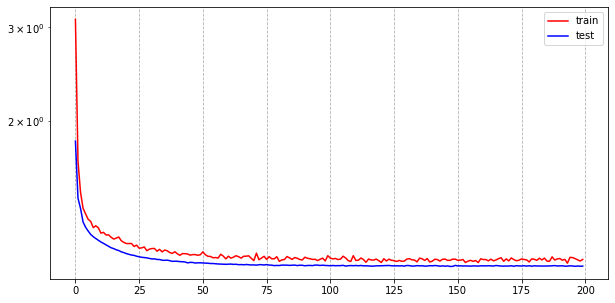

Number of parameters: 12418
nRMSE = 0.9261214832036607


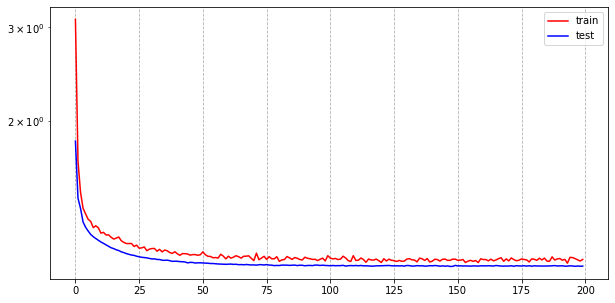

In [25]:
#N, K = 9, 8

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

lr = 0.005
optimizer_cls = optim.Adam

autoencoder = AutoEncoder_(N, K).to(device)
loss_fn = my_loss(3)
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
epoch_test_loss = []
loss_train = []
fig = plt.figure(figsize=(10,5))

for epoch in range(200):
    loss_epoch_tr = []
    for x, y in train_loader:
        out, y_pred, code = autoencoder(x.double())
        optimizer.zero_grad()
        loss = loss_fn(x.double(), y.double(), out.double(), y_pred.double())
        loss.backward()
        optimizer.step()
        loss_epoch_tr.append(loss.item())
        scheduler.step()
    loss_train.append(np.array(loss_epoch_tr).mean())
    
    with torch.no_grad():
        out, y_pred, code = autoencoder(X_test.double())
        optimizer.zero_grad()
        loss = loss_fn(X_test.double(), Y_test.double(), out.double(), y_pred.double())
        epoch_test_loss.append(loss.item())
    visualize(fig, loss_train, epoch_test_loss); 
    
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy().reshape(-1,N*K)
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy().reshape(-1,N*K)
lregr = LinearRegression()
lregr.fit(X_train_lower,Y_train.cpu().detach().numpy())
rmse = metric_nmse(X_test_lower,Y_test.cpu().detach().numpy(), lregr);
print('Number of parameters:',sum(p.numel() for p in autoencoder.parameters()))
print('nRMSE =', rmse)

### Tensor regressions
#### CP regression

In [26]:
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy()
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy()
for rank in range(1,max(N,K)+1):
    est = CPRegressor(weight_rank=rank, verbose=0)
    Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
    for i in range(3):
        est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu());
        Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
    rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
    print(rank,'nRMSE by CPR regression = ', rmse)

1 nRMSE by CPR regression =  0.9279219009882849
2 nRMSE by CPR regression =  0.9224121400906475
3 nRMSE by CPR regression =  0.9236896312518544
4 nRMSE by CPR regression =  0.9243649520617998
5 nRMSE by CPR regression =  0.9245774234151772
6 nRMSE by CPR regression =  0.9250212163056516
7 nRMSE by CPR regression =  0.9250276954809188
8 nRMSE by CPR regression =  0.9250221937523454
9 nRMSE by CPR regression =  0.9250250389892037
10 nRMSE by CPR regression =  0.9250159663542968
11 nRMSE by CPR regression =  0.9249944139666632
12 nRMSE by CPR regression =  0.9250418838029467
13 nRMSE by CPR regression =  0.9250226054584854
14 nRMSE by CPR regression =  0.9250193950938038


#### Tucker regression

In [27]:
for rank1 in range(1,K+1,1):   
    for rank2 in range(1,N+1,1):
        est = TuckerRegressor(weight_ranks=[rank1,rank2], verbose=0);
        Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
        for i in range(3):
            est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu())
            Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
        rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
        print(rank1, rank2,'nRMSE by Tucker regression = ', rmse)

1 1 nRMSE by Tucker regression =  0.9279510687875095
1 2 nRMSE by Tucker regression =  0.928072560995075
1 3 nRMSE by Tucker regression =  0.9282146870998349
1 4 nRMSE by Tucker regression =  0.9279697778613661
1 5 nRMSE by Tucker regression =  0.9279513767819182
1 6 nRMSE by Tucker regression =  0.9279341360901614
1 7 nRMSE by Tucker regression =  0.9280274069597944
1 8 nRMSE by Tucker regression =  0.9279711798934785
1 9 nRMSE by Tucker regression =  0.9280986678262413
1 10 nRMSE by Tucker regression =  0.9280616427954191
1 11 nRMSE by Tucker regression =  0.927940501380028
1 12 nRMSE by Tucker regression =  0.9280840169068139
1 13 nRMSE by Tucker regression =  0.9281319784086852
1 14 nRMSE by Tucker regression =  0.9280620158771095
2 1 nRMSE by Tucker regression =  0.927780787612845
2 2 nRMSE by Tucker regression =  0.9224342516210801
2 3 nRMSE by Tucker regression =  0.9223975497232003
2 4 nRMSE by Tucker regression =  0.9223125637083203
2 5 nRMSE by Tucker regression =  0.92257328

#### HOPLS

In [28]:
for l in range(1,max(N,K)+1):
    _,_,rmse,_ = compute_rmse_hopls(torch.tensor(X_train_lower).double(), Y_train.cpu().double(),
                              torch.tensor(X_test_lower).double(), Y_test.cpu().double(), l)
    print(l,rmse)

1 0.9444996285161259
2 0.9215941836416395
3 0.9327466814055815
4 0.9469652409695507
5 0.9609820732228463
6 0.9625351591386796
7 0.9632773096143982
8 0.9635657725056451
9 0.964238183013228
10 0.9643386654135743
11 0.9646975851356236
12 0.9661995936976592
13 0.9655725012919216
14 0.965903235472421


### With addition correlation in loss function
$$ \mathcal{L} = \mathcal{L}_{rec} + l \cdot \mathcal{L}_{dec} + m \cdot \mathcal{L}_{cor}, $$
where:
$$ \mathcal{L}_{rec} = \frac{1}{n} \sum_{i=1}^{n} \left( X_i - \psi \circ \phi (X_i) \right)^2 $$
$$ \mathcal{L}_{dec} = \frac{1}{m} \sum_{i=1}^{m} \left( Y_i - \omega \circ \phi (X_i) \right)^2 $$
$$ \mathcal{L}_{cor} = \frac{1}{k^2} \sum_{i=1}^{k} \sum_{j=1}^{k} corr(\psi(X)_i,~\psi(X)_j) $$
where $n,m,k$ - number of elements of $X$, $Y$ and $\psi(X)$, respectively.
##### Finding of best parameters for loss and learning rate

In [15]:
N, K = 14,6

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

MSE = {}
optimizer_cls = optim.Adam
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
lr = 0.005

for m in [0,0.1,1,5,10]:
    for l in [1,3,5,10]:
        MSE['m='+str(m)+', l='+str(l)] = []
        for train_index, test_index in tqdm(kf.split(X_train)):
            autoencoder = AutoEncoder_(N, K).to(device)
            loss_fn = my_loss_Q(l,m)
            optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
            epoch_test_loss = []
            epoch_train_loss = []

            train = data_utils.TensorDataset(X_train[train_index], Y_train[train_index])
            train_loader_ = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

            for epoch in range(100):
                epoch_loss = []
                for x,y in train_loader_:
                    out, y_pred, code = autoencoder(x.double())
                    optimizer.zero_grad()
                    loss = loss_fn(x.double(), y.double(), out.double(), y_pred.double(), code.double())
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    epoch_loss.append(loss.item())
                epoch_train_loss.append(np.array(epoch_loss).mean())

                with torch.no_grad():
                    out, y_pred, code = autoencoder(X_train[test_index].double())
                    optimizer.zero_grad()
                    loss = loss_fn(X_train[test_index].double(), Y_train[test_index].double(), out.double(), y_pred.double(), code.double())
                    epoch_test_loss.append(loss.item())

            X_train_lower = autoencoder.encode(X_train[train_index].double()).cpu().detach().numpy().reshape(-1,N*K)
            X_test_lower = autoencoder.encode(X_train[test_index].double()).cpu().detach().numpy().reshape(-1,N*K)
            lregr = LinearRegression()
            lregr.fit(X_train_lower,Y_train[train_index].cpu().detach().numpy())
            rmse = metric_nmse(X_test_lower,Y_train[test_index].cpu().detach().numpy(), lregr);
            MSE['m='+str(m)+', l='+str(l)].append(rmse)
            # print('m='+str(m)+', l='+str(l)+', lr='+str(lr))
            # print(sum(p.numel() for p in autoencoder.parameters()))
            # print('nRMSE =', rmse)

3it [02:36, 52.06s/it]
3it [02:34, 51.55s/it]
3it [02:32, 50.95s/it]
3it [02:33, 51.05s/it]
3it [02:33, 51.04s/it]
3it [02:32, 50.78s/it]
3it [02:33, 51.29s/it]
3it [02:34, 51.65s/it]
3it [02:31, 50.40s/it]
3it [02:33, 51.02s/it]
3it [02:32, 50.81s/it]
3it [02:32, 50.96s/it]
3it [02:31, 50.59s/it]
3it [02:33, 51.06s/it]
3it [02:31, 50.58s/it]
3it [02:33, 51.10s/it]
3it [02:31, 50.63s/it]
3it [02:33, 51.15s/it]
3it [02:33, 51.16s/it]
3it [02:32, 50.79s/it]


In [16]:
for key in MSE:
    MSE[key] = np.array(MSE[key]).mean()

print('Best parameters are', min(MSE, key=MSE.get), 'nRMSE =', MSE[min(MSE, key=MSE.get)])

Best parameters are m=1, l=5 nRMSE = 1.0741340807673014


##### Finding of best parameters for autoencoder

In [19]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

lr = 0.005
optimizer_cls = optim.Adam
MSE = []
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
# Finding best N
for n,N_ch in enumerate(range(2,11,1)):
    for k,N_f in enumerate(range(2,11,2)):
        MSE.append([])
        for train_index, test_index in tqdm(kf.split(X_train)):
        # Instantiate model
            autoencoder = AutoEncoder_(N_ch,N_f).to(device)
            loss_fn = my_loss_Q(5,1)
            optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
            epoch_test_loss = []
            epoch_train_loss = []

            train = data_utils.TensorDataset(X_train[train_index], Y_train[train_index])
            train_loader_ = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

            for epoch in range(100):
                epoch_loss = []
                for x,y in train_loader_:
                    out, y_pred, code = autoencoder(x.double())
                    optimizer.zero_grad()
                    loss = loss_fn(x.double(), y.double(), out.double(), y_pred.double(), code.double())
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    epoch_loss.append(loss.item())
                epoch_train_loss.append(np.array(epoch_loss).mean())
                
                with torch.no_grad():
                    out, y_pred, code = autoencoder(X_train[test_index].double())
                    optimizer.zero_grad()
                    loss = loss_fn(X_train[test_index].double(), Y_train[test_index].double(), out.double(), y_pred.double(), code.double())
                    epoch_test_loss.append(loss.item())
                    
            X_train_lower = autoencoder.encode(X_train[train_index].double()).cpu().detach().numpy().reshape(-1,N_f*N_ch)
            X_test_lower = autoencoder.encode(X_train[test_index].double()).cpu().detach().numpy().reshape(-1,N_f*N_ch)
            lregr = LinearRegression()
            lregr.fit(X_train_lower,Y_train[train_index].cpu().detach().numpy())
            rmse = metric_nmse(X_test_lower,Y_train[test_index].cpu().detach().numpy(), lregr)
            MSE[n*5+k].append(rmse)

3it [01:43, 34.52s/it]
3it [01:56, 38.94s/it]
3it [02:12, 44.08s/it]
3it [02:26, 48.92s/it]
3it [02:43, 54.52s/it]
3it [01:44, 34.69s/it]
3it [01:57, 39.29s/it]
3it [02:13, 44.59s/it]
3it [02:27, 49.24s/it]
3it [02:45, 55.05s/it]
3it [01:43, 34.61s/it]
3it [01:57, 39.10s/it]
3it [02:14, 44.71s/it]
3it [02:29, 49.93s/it]
3it [02:47, 55.67s/it]
3it [01:43, 34.54s/it]
3it [01:58, 39.61s/it]
3it [02:15, 45.05s/it]
3it [02:31, 50.64s/it]
3it [02:50, 56.92s/it]
3it [01:43, 34.44s/it]
3it [01:59, 39.70s/it]
3it [02:16, 45.60s/it]
3it [02:33, 51.24s/it]
3it [02:53, 57.89s/it]
3it [01:44, 34.80s/it]
3it [02:01, 40.44s/it]
3it [02:18, 46.00s/it]
3it [02:37, 52.37s/it]
3it [03:04, 61.57s/it]
3it [01:36, 32.30s/it]
3it [01:52, 37.41s/it]
3it [02:11, 43.76s/it]
3it [02:31, 50.46s/it]
3it [03:02, 60.91s/it]
3it [01:38, 32.84s/it]
3it [01:53, 37.83s/it]
3it [02:13, 44.38s/it]
3it [02:43, 54.38s/it]
3it [03:08, 62.91s/it]
3it [01:37, 32.54s/it]
3it [01:54, 38.23s/it]
3it [02:16, 45.51s/it]
3it [02:45,

In [20]:
rmse = 2
N, K = 0, 0
for n,N_ch in enumerate(range(2,11,1)):
    for k,N_f in enumerate(range(2,11,2)):
        if rmse > np.array(MSE[n*5+k]).mean():
            N = N_ch
            K = N_f
            rmse = np.array(MSE[n*5+k]).mean()
print(N, K, rmse)

9 6 1.081545649051071


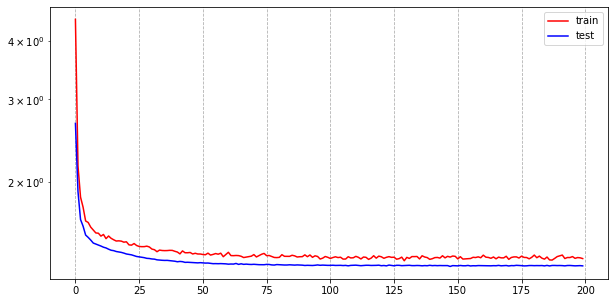

10548
nRMSE = 0.9399059573766054


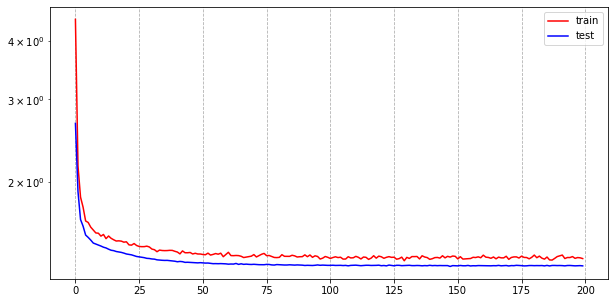

In [22]:
#N, K = 10, 10

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

lr = 0.005
optimizer_cls = optim.Adam

autoencoder = AutoEncoder_(N, K).to(device)
loss_fn = my_loss_Q(5,1)
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
epoch_test_loss = []
loss_train = []
fig = plt.figure(figsize=(10,5))

for epoch in range(200):
    loss_epoch_tr = []
    for x, y in train_loader:
        out, y_pred, code = autoencoder(x.double())
        optimizer.zero_grad()
        loss = loss_fn(x.double(), y.double(), out.double(), y_pred.double(), code.double())
        loss.backward()
        optimizer.step()
        loss_epoch_tr.append(loss.item())
        scheduler.step()
    loss_train.append(np.array(loss_epoch_tr).mean())
    
    with torch.no_grad():
        out, y_pred, code = autoencoder(X_test.double())
        optimizer.zero_grad()
        loss = loss_fn(X_test.double(), Y_test.double(), out.double(), y_pred.double(), code.double())
        epoch_test_loss.append(loss.item())
    visualize(fig, loss_train, epoch_test_loss); 
    
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy().reshape(-1,N*K)
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy().reshape(-1,N*K)
lregr = LinearRegression()
lregr.fit(X_train_lower,Y_train.cpu().detach().numpy())
rmse = metric_nmse(X_test_lower,Y_test.cpu().detach().numpy(), lregr);
print(sum(p.numel() for p in autoencoder.parameters()))
print('nRMSE =', rmse)

In [23]:
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy()
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy()
for rank in range(1,max(N,K)+1):
    est = CPRegressor(weight_rank=rank, verbose=0)
    Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
    for i in range(3):
        est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu());
        Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
    rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
    print(rank,'nRMSE by CPR regression = ', rmse)

1 nRMSE by CPR regression =  0.9540182185333889
2 nRMSE by CPR regression =  0.9428951778052226
3 nRMSE by CPR regression =  0.9416829056745764
4 nRMSE by CPR regression =  0.9422797425545832
5 nRMSE by CPR regression =  0.940871910108982
6 nRMSE by CPR regression =  0.9410115129065465
7 nRMSE by CPR regression =  0.9410179930334852
8 nRMSE by CPR regression =  0.9410082780974439
9 nRMSE by CPR regression =  0.9410033154605246


In [24]:
for rank1 in range(1,K+1,1):   
    for rank2 in range(1,N+1,1):
        est = TuckerRegressor(weight_ranks=[rank1,rank2], verbose=0);
        Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
        for i in range(3):
            est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu())
            Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
        rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
        print(rank1, rank2,'nRMSE by Tucker regression = ', rmse)

1 1 nRMSE by Tucker regression =  0.9639974226358053
1 2 nRMSE by Tucker regression =  0.9539526071089816
1 3 nRMSE by Tucker regression =  0.9620702024527223
1 4 nRMSE by Tucker regression =  0.9539382146046705
1 5 nRMSE by Tucker regression =  0.955842127640342
1 6 nRMSE by Tucker regression =  0.9640055355962973
1 7 nRMSE by Tucker regression =  0.962151471941674
1 8 nRMSE by Tucker regression =  0.9540984918931326
1 9 nRMSE by Tucker regression =  0.9540520172540177
2 1 nRMSE by Tucker regression =  0.9639228578360464
2 2 nRMSE by Tucker regression =  0.9457181828160207
2 3 nRMSE by Tucker regression =  0.9430371300066486
2 4 nRMSE by Tucker regression =  0.9453546339848211
2 5 nRMSE by Tucker regression =  0.9454066432129459
2 6 nRMSE by Tucker regression =  0.9453802119213411
2 7 nRMSE by Tucker regression =  0.9456880117919786
2 8 nRMSE by Tucker regression =  0.9453530960774397
2 9 nRMSE by Tucker regression =  0.9458018874225361
3 1 nRMSE by Tucker regression =  0.953951071962

### Autoencoder with different number of dimensions

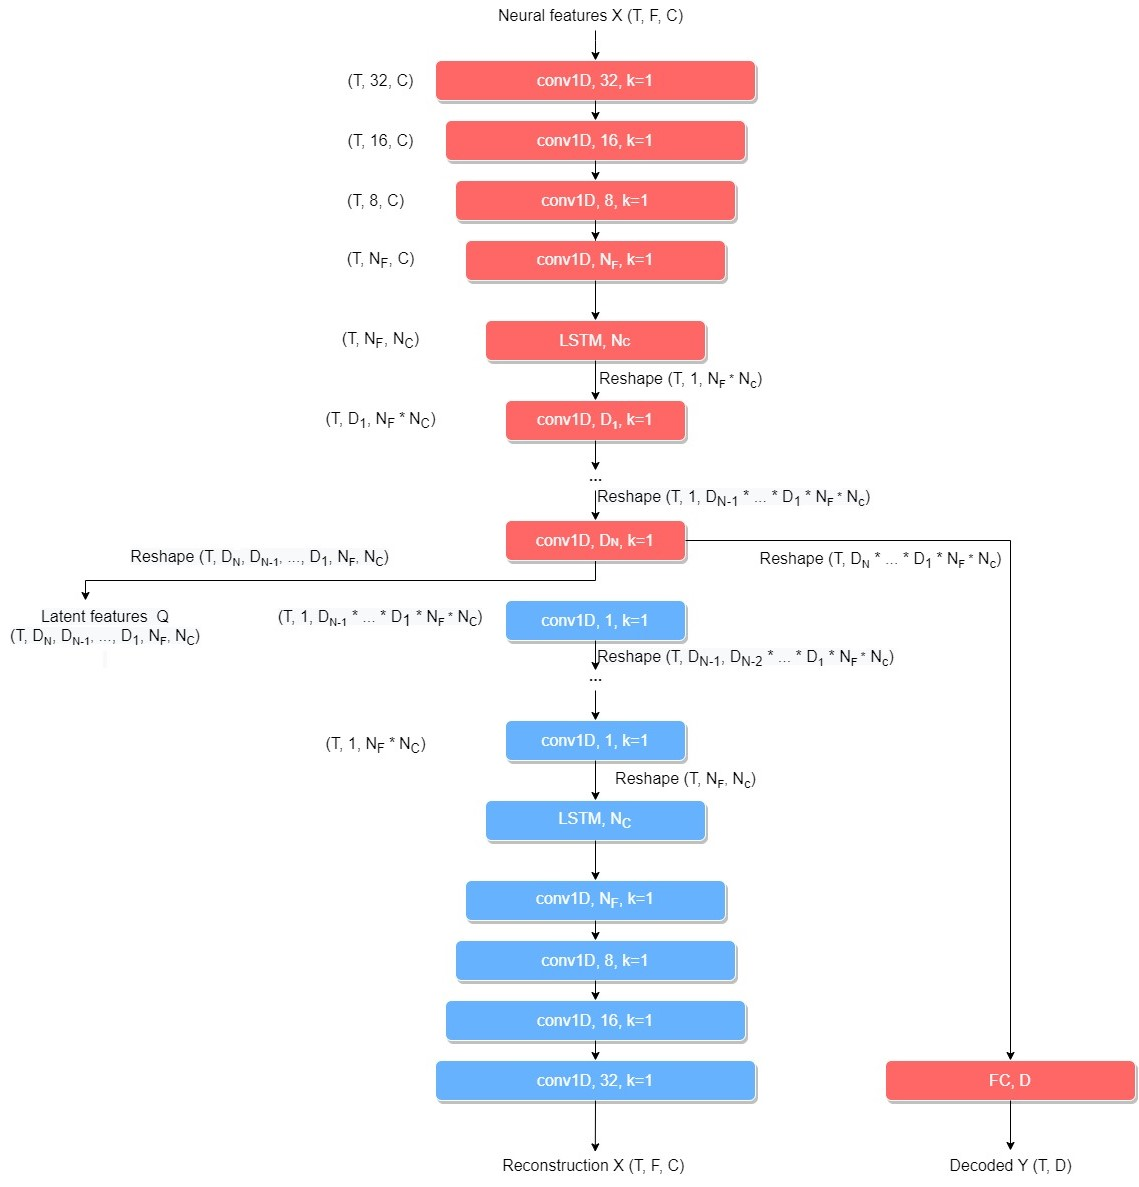

In [12]:
class AutoEncoder_d(nn.Module):
    def __init__(self, N_ch, N_f, f_dim=None):
        super().__init__()
        '''
        f_dim - list
        '''
        self.N_ch = N_ch
        self.N_f = N_f
        # Encoder specification
        self.enc_cnn_1 = nn.Sequential(
            nn.Conv1d(IMAGE_WIDTH, 32, 1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(p=0.05))
        self.enc_cnn_2 = nn.Sequential(
            nn.Conv1d(32, 16, 1),
            nn.BatchNorm1d(16),
            nn.GELU(),
            nn.Dropout(p=0.05)) 
        if N_f >= 8:
            self.enc_cnn_3 = nn.Sequential(
                nn.Conv1d(16, N_f, 1),
                nn.BatchNorm1d(N_f),
                nn.GELU(),
                nn.Dropout(p=0.05))
        elif N_f < 8:
            self.enc_cnn_3 = nn.Sequential(
                nn.Conv1d(16, 8, 1),
                nn.BatchNorm1d(8),
                nn.GELU(),
                nn.Dropout(p=0.05))
            self.enc_cnn_4 = nn.Sequential(
                nn.Conv1d(8, N_f, 1),
                nn.BatchNorm1d(N_f),
                nn.GELU(),
                nn.Dropout(p=0.05))
        self.enc_lstm = nn.LSTM(IMAGE_HEIGHT, N_ch, 1,batch_first=True)
        
        # Decoder specification
        self.dec_lstm = nn.LSTM(N_ch, IMAGE_HEIGHT, 1,batch_first=True)
            
        if N_f < 8:
            self.dec_cnn_1 = nn.Sequential(
                nn.Conv1d(N_f, 8, 1),
                nn.BatchNorm1d(8),
                nn.GELU(),
                nn.Dropout(p=0.05))
            self.dec_cnn_2 = nn.Sequential(
                nn.Conv1d(8, 16, 1),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Dropout(p=0.05)) 
        else:
            self.dec_cnn_2 = nn.Sequential(
                nn.Conv1d(N_f, 16, 1),
                nn.BatchNorm1d(16),
                nn.GELU(),
                nn.Dropout(p=0.05))
        self.dec_cnn_3 = nn.Sequential(
            nn.Conv1d(16, 32, 1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Dropout(p=0.05))
        self.dec_cnn_4 = nn.Sequential(
            nn.Conv1d(32, IMAGE_WIDTH, 1),
            nn.BatchNorm1d(IMAGE_WIDTH),
            nn.GELU(),
            nn.Dropout(p=0.05))
        
        self.fdim = f_dim
        if f_dim != None:
            self.fc = nn.Linear(np.prod(self.fdim)*N_ch*N_f, 3)
            fc_list_up = []
            fc_list_down = []
            for f_d in f_dim:
                fc_list_up.append(nn.Sequential(nn.Conv1d(1, f_d, 1),nn.BatchNorm1d(f_d),nn.GELU(),nn.Dropout(p=0.05),
                                                nn.Conv1d(f_d, f_d, 1),nn.BatchNorm1d(f_d),nn.GELU(),nn.Dropout(p=0.05)))
                fc_list_down.append(nn.Sequential(nn.Conv1d(f_d, f_d, 1),nn.BatchNorm1d(f_d),nn.GELU(),nn.Dropout(p=0.05),
                                                  nn.Conv1d(f_d, 1, 1),nn.BatchNorm1d(1),nn.GELU(),nn.Dropout(p=0.05)))
            self.fc_list_up =  nn.ModuleList(fc_list_up)   
            self.fc_list_down =  nn.ModuleList(fc_list_down[::-1]) 
        else:
            self.fc = nn.Linear(N_ch*N_f, 3)
        
        
    def forward(self, images):
        code = self.encode(images)
        y_pred = self.fc(code.reshape([code.size(0),-1]))
        out = self.decode(code)
        return out, y_pred, code
    
    def encode(self, images):
        code = self.enc_cnn_1(images)
        code = self.enc_cnn_2(code)
        if self.N_f < 8:
            code = self.enc_cnn_3(code)
            code = self.enc_cnn_4(code)
        else:
            code = self.enc_cnn_3(code)
        #code = code.reshape([1,code.size(0),code.size(2)*2])
        code,_ = self.enc_lstm(code)
        if self.fdim != None:
            for layer in self.fc_list_up:
                code = layer(code.reshape(code.size(0),1,-1))  
            code = code.reshape([code.size(0)]+self.fdim[::-1]+[self.N_f,self.N_ch])
        return code
    
    def decode(self, out):
        if self.fdim != None:
            for i,layer in enumerate(self.fc_list_down):
                out = layer(out.reshape(out.size(0),self.fdim[::-1][i],-1))
            out = out.reshape(out.size(0),self.N_f,self.N_ch)
        out,_ = self.dec_lstm(out)
        #out = out.reshape([out.size(1),2,out.size(2)//2])
        if self.N_f < 8:
            out = self.dec_cnn_1(out)
            out = self.dec_cnn_2(out)
        else:
            out = self.dec_cnn_2(out)
        out = self.dec_cnn_3(out)
        out = self.dec_cnn_4(out)
        return out

In [26]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

N, K = 14, 6
lr = 0.01
optimizer_cls = optim.Adam
MSE = []
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)

f_dims = [None,[2],[3],[4],[5],[6],[7],[8],[2,2],[2,3],[3,2]]
for f,f_dim in enumerate(f_dims):
    for n,N_ch in enumerate(range(N-1,N+2)):
        for k,N_f in enumerate(range(K-1,K+2)):
            MSE.append([])
            for train_index, test_index in tqdm(kf.split(X_train)):
            # Instantiate model
                autoencoder = AutoEncoder_d(N_ch,N_f,f_dim).to(device)
                loss_fn = my_loss(3)
                optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
                epoch_train_loss = []
                epoch_test_loss = []

                train = data_utils.TensorDataset(X_train[train_index], Y_train[train_index])
                train_loader_ = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

                for epoch in range(100):
                    epoch_loss = []
                    for x,y in train_loader_:
                        out, y_pred, code = autoencoder(x.double())
                        optimizer.zero_grad()
                        loss = loss_fn(x.double(), y.double(), out.double(), y_pred.double())
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                        epoch_loss.append(loss.item())
                    epoch_train_loss.append(np.array(epoch_loss).mean())

                    with torch.no_grad():
                        out, y_pred, code = autoencoder(X_train[test_index].double())
                        optimizer.zero_grad()
                        loss = loss_fn(X_train[test_index].double(), Y_train[test_index].double(), out.double(), y_pred.double())
                        epoch_test_loss.append(loss.item())

                X_train_lower = autoencoder.encode(X_train[train_index].double()).cpu().detach().numpy().reshape(len(train_index),-1)
                X_test_lower = autoencoder.encode(X_train[test_index].double()).cpu().detach().numpy().reshape(len(test_index),-1)
                lregr = LinearRegression()
                lregr.fit(X_train_lower,Y_train[train_index].cpu().detach().numpy())
                rmse = metric_nmse(X_test_lower,Y_train[test_index].cpu().detach().numpy(), lregr)
                MSE[f*3*3+n*3+k].append(rmse)
#             print(sum(p.numel() for p in autoencoder.parameters()))
#             print(np.array(MSE).mean(),'+-',np.array(MSE).std(), f_dim, N_f, N_ch)

3it [02:03, 41.29s/it]
3it [02:11, 43.93s/it]
3it [02:19, 46.34s/it]
3it [02:03, 41.22s/it]
3it [02:11, 43.82s/it]
3it [02:18, 46.06s/it]
3it [02:03, 41.22s/it]
3it [02:11, 43.81s/it]
3it [02:18, 46.29s/it]
3it [02:23, 47.83s/it]
3it [02:34, 51.39s/it]
3it [02:43, 54.65s/it]
3it [02:25, 48.37s/it]
3it [02:36, 52.14s/it]
3it [02:51, 57.04s/it]
3it [02:26, 48.75s/it]
3it [02:37, 52.55s/it]
3it [02:52, 57.66s/it]
3it [02:23, 47.87s/it]
3it [02:34, 51.39s/it]
3it [02:44, 54.75s/it]
3it [02:24, 48.31s/it]
3it [02:36, 52.03s/it]
3it [02:51, 57.04s/it]
3it [02:26, 48.68s/it]
3it [02:37, 52.59s/it]
3it [02:52, 57.46s/it]
3it [02:24, 48.28s/it]
3it [02:36, 52.00s/it]
3it [02:45, 55.24s/it]
3it [02:26, 48.91s/it]
3it [02:38, 52.86s/it]
3it [02:53, 57.70s/it]
3it [02:27, 49.33s/it]
3it [02:39, 53.15s/it]
3it [02:54, 58.29s/it]
3it [02:28, 49.54s/it]
3it [02:39, 53.30s/it]
3it [02:50, 56.69s/it]
3it [02:29, 49.88s/it]
3it [02:40, 53.66s/it]
3it [02:57, 59.11s/it]
3it [02:31, 50.35s/it]
3it [02:43,

In [27]:
rmse = 2
N, K, F = 0, 0, 0
for f,f_dim in enumerate(f_dims):
    for n,N_ch in enumerate(range(13,16)):
        for k,N_f in enumerate(range(5,8)):
            if (f_dim!=None):
                if rmse > np.array(MSE[f*3*3+n*3+k]).mean():
                    N = N_ch
                    K = N_f
                    F = f_dim
                    rmse = np.array(MSE[f*3*3+n*3+k]).mean()
print(N, K, F, rmse)

14 5 [2] 1.0875993718537076


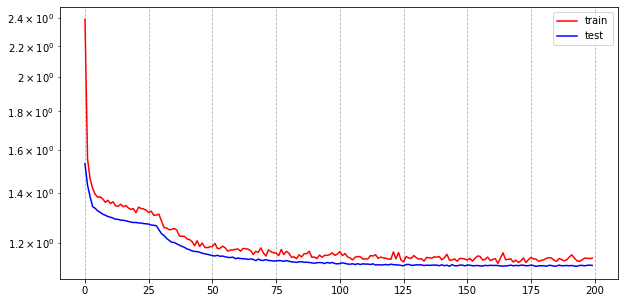

12808
nRMSE = 0.9374513507122465


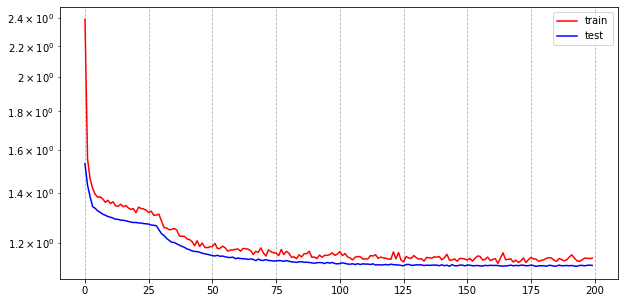

In [28]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

f_dim, N_f, N_ch = F, K, N
lr = 0.01
optimizer_cls = optim.Adam

autoencoder = AutoEncoder_d(N_ch, N_f, f_dim).to(device)
loss_fn = my_loss(3)
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
epoch_test_loss = []
loss_train = []
fig = plt.figure(figsize=(10,5))

for epoch in range(200):
    loss_epoch_tr = []
    for x, y in train_loader:
        out, y_pred, code = autoencoder(x.double())
        optimizer.zero_grad()
        loss = loss_fn(x.double(), y.double(), out.double(), y_pred.double())
        loss.backward()
        optimizer.step()
        loss_epoch_tr.append(loss.item())
        scheduler.step()
    loss_train.append(np.array(loss_epoch_tr).mean())
    
    with torch.no_grad():
        out, y_pred, code = autoencoder(X_test.double())
        optimizer.zero_grad()
        loss = loss_fn(X_test.double(), Y_test.double(), out.double(), y_pred.double())
        epoch_test_loss.append(loss.item())
    visualize(fig, loss_train, epoch_test_loss); 
    
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy().reshape(X_train.size(0),-1)
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy().reshape(X_test.size(0),-1)
                    
lregr = LinearRegression()
lregr.fit(X_train_lower,Y_train.cpu().detach().numpy())
rmse = metric_nmse(X_test_lower,Y_test.cpu().detach().numpy(), lregr);
print(sum(p.numel() for p in autoencoder.parameters()))
print('nRMSE =', rmse)

In [29]:
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy()
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy()
X_train_lower.shape

(12801, 2, 5, 14)

In [30]:
for rank in range(1,f_dim[0]+1,1):
    for rank1 in range(1,K+1,1):   
        for rank2 in range(1,N+1,1):
            est = TuckerRegressor(weight_ranks=[rank,rank1,rank2], verbose=0);
            Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
            for i in range(3):
                est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu())
                Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
            rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
            print(rank, rank1, rank2,'nRMSE by Tucker regression = ', rmse)

1 1 1 nRMSE by Tucker regression =  0.936710436924078
1 1 2 nRMSE by Tucker regression =  0.9363377268960997
1 1 3 nRMSE by Tucker regression =  0.9365334628188705
1 1 4 nRMSE by Tucker regression =  0.9452999827604192
1 1 5 nRMSE by Tucker regression =  0.9367741460715294
1 1 6 nRMSE by Tucker regression =  0.9366230696476504
1 1 7 nRMSE by Tucker regression =  0.9366086209828008
1 1 8 nRMSE by Tucker regression =  0.935605119734586
1 1 9 nRMSE by Tucker regression =  0.9365642535719698
1 1 10 nRMSE by Tucker regression =  0.9365815015544273
1 1 11 nRMSE by Tucker regression =  0.9366124449265687
1 1 12 nRMSE by Tucker regression =  0.9459023214786618
1 1 13 nRMSE by Tucker regression =  0.9454734964037687
1 1 14 nRMSE by Tucker regression =  0.9361886610440399
1 2 1 nRMSE by Tucker regression =  0.9362460811833205
1 2 2 nRMSE by Tucker regression =  0.932520227827474
1 2 3 nRMSE by Tucker regression =  0.9325940957700101
1 2 4 nRMSE by Tucker regression =  0.9333177860921217
1 2 5 nR

## With other loss

In [14]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

N, K = 9,6
lr = 0.005
optimizer_cls = optim.Adam
MSE = {}
kf = KFold(n_splits=3)
kf.get_n_splits(X_train)
# Finding best N
f_dims = [None,[2],[3]]
for f,f_dim in enumerate(f_dims):
    if f_dim==None:
        n_range = [9]
        k_range = [6]
    elif f_dim[0]==2:
        n_range = range(6,11)
        k_range = range(4,7)
    elif f_dim[0]==3:
        n_range = range(1,6)
        k_range = range(1,5)
    for n,N_ch in enumerate(n_range):
        for k,N_f in enumerate(k_range):
            MSE['f_dim='+str(f_dim)+', N_f='+str(N_f)+', N_ch=',str(N_ch)] = []
            for train_index, test_index in tqdm(kf.split(X_train[:X_train.shape[0]])):
            # Instantiate model
                autoencoder = AutoEncoder_d(N_ch,N_f,f_dim).to(device)
                loss_fn = my_loss_Q(5,1)
                optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
                epoch_train_loss = []
                epoch_test_loss = []

                for epoch in range(100):
                    #print("Epoch %d" % epoch)
                    epoch_loss = []
                    out, y_pred, code = autoencoder(X_train[train_index].double())
                    optimizer.zero_grad()
                    loss = loss_fn(X_train[train_index].double(), Y_train[train_index].double(), out.double(), y_pred.double(), code.double())
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    epoch_train_loss.append(loss.item())

                    with torch.no_grad():
                        out, y_pred, code = autoencoder(X_train[test_index].double())
                        optimizer.zero_grad()
                        loss = loss_fn(X_train[test_index].double(), Y_train[test_index].double(), out.double(), y_pred.double(), code.double())
                        epoch_test_loss.append(loss.item())

                X_train_lower = autoencoder.encode(X_train[train_index].double()).cpu().detach().numpy().reshape(len(train_index),-1)
                X_test_lower = autoencoder.encode(X_train[test_index].double()).cpu().detach().numpy().reshape(len(test_index),-1)
                lregr = LinearRegression()
                lregr.fit(X_train_lower,Y_train[train_index].cpu().detach().numpy())
                rmse = metric_nmse(X_test_lower,Y_train[test_index].cpu().detach().numpy(), lregr)
                MSE['f_dim='+str(f_dim)+', N_f='+str(N_f)+', N_ch=',str(N_ch)].append(rmse)

3it [01:47, 35.97s/it]
3it [01:46, 35.57s/it]
3it [01:59, 39.86s/it]
3it [02:17, 45.89s/it]
3it [01:46, 35.65s/it]
3it [02:05, 41.78s/it]
3it [02:24, 48.23s/it]
3it [01:48, 36.32s/it]
3it [02:11, 43.87s/it]
3it [02:33, 51.09s/it]
3it [02:04, 41.36s/it]
3it [02:22, 47.49s/it]
3it [02:47, 55.71s/it]
3it [02:05, 41.76s/it]
3it [02:36, 52.16s/it]
3it [03:03, 61.24s/it]
3it [01:02, 20.93s/it]
3it [01:11, 23.87s/it]
3it [01:22, 27.66s/it]
3it [01:23, 27.90s/it]
3it [01:03, 21.32s/it]
3it [01:14, 24.84s/it]
3it [01:24, 28.16s/it]
3it [01:30, 30.00s/it]
3it [01:04, 21.48s/it]
3it [01:20, 26.69s/it]
3it [01:27, 29.09s/it]
3it [01:35, 31.73s/it]
3it [01:06, 22.32s/it]
3it [01:22, 27.47s/it]
3it [01:29, 29.95s/it]
3it [01:39, 33.30s/it]
3it [01:06, 22.29s/it]
3it [01:22, 27.66s/it]
3it [01:33, 31.21s/it]
3it [01:47, 35.79s/it]


In [17]:
for key in MSE:
    MSE[key] = np.array(MSE[key]).mean()

print('Best parameters are', min(MSE, key=MSE.get), ', nRMSE =', MSE[min(MSE, key=MSE.get)])

Best parameters are ('f_dim=[2], N_f=4, N_ch=', '10') , nRMSE = 1.1112708877251622


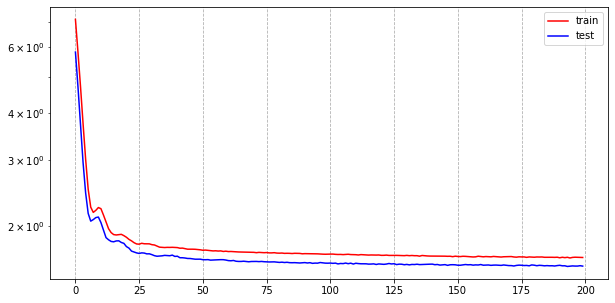

Number of parameters: 11169
nRMSE = 0.9700348642203833


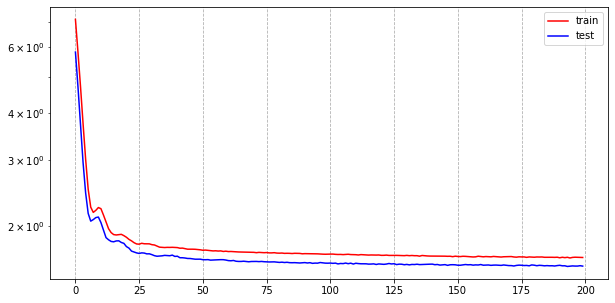

In [18]:
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

f_dim, N_f, N_ch = [2], 4, 10
#[5], 1, 8
#[3, 2], 1, 4
lr = 0.005
optimizer_cls = optim.Adam

autoencoder = AutoEncoder_d(N_ch, N_f, f_dim).to(device)
loss_fn = my_loss_Q(5,1)
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.75)
epoch_test_loss = []
loss_train = []
fig = plt.figure(figsize=(10,5))

for epoch in range(200):
    out, y_pred, code = autoencoder(X_train.double())
    optimizer.zero_grad()
    loss = loss_fn(X_train.double(), Y_train.double(), out.double(), y_pred.double(), code.double())
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss_train.append(loss.item())
    
    with torch.no_grad():
        out, y_pred, code = autoencoder(X_test.double())
        optimizer.zero_grad()
        loss = loss_fn(X_test.double(), Y_test.double(), out.double(), y_pred.double(), code.double())
        epoch_test_loss.append(loss.item())
    visualize(fig, loss_train, epoch_test_loss); 
    
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy().reshape(X_train.size(0),-1)
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy().reshape(X_test.size(0),-1)
                    
lregr = LinearRegression()
lregr.fit(X_train_lower,Y_train.cpu().detach().numpy())
rmse = metric_nmse(X_test_lower,Y_test.cpu().detach().numpy(), lregr);
print('Number of parameters:', sum(p.numel() for p in autoencoder.parameters()))
print('nRMSE =', rmse)

In [19]:
X_train_lower = autoencoder.encode(X_train.double()).cpu().detach().numpy()
X_test_lower = autoencoder.encode(X_test.double()).cpu().detach().numpy()
X_train_lower.shape

(12801, 2, 4, 10)

In [20]:
for rank in range(1,f_dim[0]+1,1):
    for rank1 in range(1,N_f+1,1):   
        for rank2 in range(1,N_ch+1,1):
            est = TuckerRegressor(weight_ranks=[rank,rank1,rank2], verbose=0);
            Y_pred = np.zeros(Y_test.cpu().detach().numpy().shape)
            for i in range(3):
                est.fit(torch.tensor(X_train_lower).cpu().double(), Y_train[:, i].double().cpu())
                Y_pred[:, i] = est.predict(torch.tensor(X_test_lower).cpu().double())
            rmse = metric_nmse_(Y_pred, Y_test.cpu().detach().numpy())
            print(rank, rank1, rank2,'nRMSE by Tucker regression = ', rmse)

1 1 1 nRMSE by Tucker regression =  0.97658662979392
1 1 2 nRMSE by Tucker regression =  0.9765919437958015
1 1 3 nRMSE by Tucker regression =  0.9764212518741199
1 1 4 nRMSE by Tucker regression =  0.9762180604515683
1 1 5 nRMSE by Tucker regression =  0.9765391797970407
1 1 6 nRMSE by Tucker regression =  0.9767121442895221
1 1 7 nRMSE by Tucker regression =  0.9763570652111803
1 1 8 nRMSE by Tucker regression =  0.9768586972813506
1 1 9 nRMSE by Tucker regression =  0.9768805970812445
1 1 10 nRMSE by Tucker regression =  0.9768328230820943
1 2 1 nRMSE by Tucker regression =  0.9765527491536314
1 2 2 nRMSE by Tucker regression =  0.9748039264398423
1 2 3 nRMSE by Tucker regression =  0.9751225853033105
1 2 4 nRMSE by Tucker regression =  0.9748119102771668
1 2 5 nRMSE by Tucker regression =  0.9748384181480727
1 2 6 nRMSE by Tucker regression =  0.9746574123098902
1 2 7 nRMSE by Tucker regression =  0.9750362175227868
1 2 8 nRMSE by Tucker regression =  0.9759755505549866
1 2 9 nRMSE

## All results

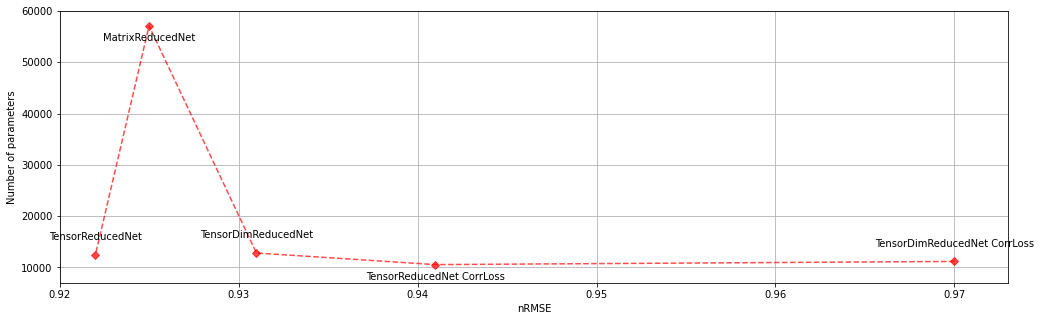

In [24]:
labels = ['TensorDimReducedNet CorrLoss', 'TensorReducedNet CorrLoss', 'TensorDimReducedNet', 'MatrixReducedNet', 'TensorReducedNet']
colors = ['r', 'b', 'black', 'y', 'purple'] 
x = [0.970, 0.941, 0.931, 0.925, 0.922]
y = [11169,10548,12808,57106,12418]
fig = plt.figure(figsize=(17,5))
plt.plot(x, y, '-gD', linestyle="--", color='red', alpha=0.7)
for i,(xitem,yitem) in enumerate(np.nditer([x,y])):
    plt.annotate(labels[i], (xitem,yitem), textcoords="offset points",xytext=(0,(-1)**i*15),ha="center")
plt.xlim(0.920,0.973)
plt.ylim(7000,60000)
plt.xlabel('nRMSE')
plt.ylabel('Number of parameters')
plt.grid(True)
plt.show()